# Hungary Load Forecasting - Model Training

Macaristan elektrik yük tahmini için Dense Neural Network modeli eğitimi.
Romanya çalışması referans alınarak aynı mimari kullanılmıştır.

**Veri Dönemleri:**
- Training: 2015-01-01 - 2017-12-31
- Validation: 2018-01-01 - 2018-12-31
- Test: 2019-01-01 - 2019-12-31


In [ ]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.utils import plot_model

# Scikit-learn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
MODEL_NAME = "yours"
print("✅ Model:", MODEL_NAME)


## 1. Veri Yükleme ve İnceleme


In [ ]:
# Load the merged dataset
data_path = "../data/processed/hungary_merged_dataset_2015_2024.csv"
df = pd.read_csv(data_path)

# Datetime'ı parse et
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

# Sıralı olduğundan emin ol
df = df.sort_values('datetime').reset_index(drop=True)

print(f"📊 Dataset Bilgileri:")
print(f"Toplam kayıt: {len(df):,}")
print(f"Toplam sütun: {len(df.columns)}")
print(f"Tarih aralığı: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"\nİlk 5 kayıt:")
print(df.head())
print(f"\nEksik değerler:")
missing = df.isnull().sum()
print(missing[missing > 0])

Mounted at /content/drive
📊 Dataset Bilgileri:
Toplam kayıt: 350,688
Toplam sütun: 79
Tarih aralığı: 2015-01-01 00:00:00+00:00 - 2024-12-31 23:45:00+00:00

İlk 5 kayıt:
                   datetime  load_MW  load_MW_lag_48h  load_MW_lag_72h  \
0 2015-01-01 00:00:00+00:00  4164.73              NaN              NaN   
1 2015-01-01 00:15:00+00:00  4106.20              NaN              NaN   
2 2015-01-01 00:30:00+00:00  4053.31              NaN              NaN   
3 2015-01-01 00:45:00+00:00  3952.49              NaN              NaN   
4 2015-01-01 01:00:00+00:00  3863.72              NaN              NaN   

   load_MW_lag_96h  load_MW_lag_120h  load_MW_lag_144h  load_MW_lag_168h  \
0              NaN               NaN               NaN               NaN   
1              NaN               NaN               NaN               NaN   
2              NaN               NaN               NaN               NaN   
3              NaN               NaN               NaN               NaN   
4     

## 2. Train/Validation/Test Split


In [ ]:
# Define date ranges (chronological split)
train_start = pd.Timestamp('2016-01-01', tz='UTC')
train_end = pd.Timestamp('2017-12-31 23:45:00', tz='UTC')

val_start = pd.Timestamp('2018-01-01', tz='UTC')
val_end = pd.Timestamp('2018-12-31 23:45:00', tz='UTC')

test_start = pd.Timestamp('2019-01-01', tz='UTC')
test_end = pd.Timestamp('2019-12-31 23:45:00', tz='UTC')

# Split
train_df = df[(df['datetime'] >= train_start) & (df['datetime'] <= train_end)].copy()
val_df = df[(df['datetime'] >= val_start) & (df['datetime'] <= val_end)].copy()
test_df = df[(df['datetime'] >= test_start) & (df['datetime'] <= test_end)].copy()

print(f"📊 Veri Split Bilgileri:")
print(f"\nTraining Set:")
print(f"  Kayıt sayısı: {len(train_df):,}")
print(f"  Tarih aralığı: {train_df['datetime'].min()} - {train_df['datetime'].max()}")
print(f"\nValidation Set:")
print(f"  Kayıt sayısı: {len(val_df):,}")
print(f"  Tarih aralığı: {val_df['datetime'].min()} - {val_df['datetime'].max()}")
print(f"\nTest Set:")
print(f"  Kayıt sayısı: {len(test_df):,}")
print(f"  Tarih aralığı: {test_df['datetime'].min()} - {test_df['datetime'].max()}")


📊 Veri Split Bilgileri:

Training Set:
  Kayıt sayısı: 103,872
  Tarih aralığı: 2015-01-15 00:00:00+00:00 - 2017-12-31 23:45:00+00:00

Validation Set:
  Kayıt sayısı: 35,040
  Tarih aralığı: 2018-01-01 00:00:00+00:00 - 2018-12-31 23:45:00+00:00

Test Set:
  Kayıt sayısı: 35,040
  Tarih aralığı: 2019-01-01 00:00:00+00:00 - 2019-12-31 23:45:00+00:00


## 3. Feature Seçimi


In [ ]:
# Target variable
target_col = 'load_MW'

# Feature categories
lag_features = [col for col in df.columns if 'lag' in col]
rolling_features = [col for col in df.columns if 'rolling' in col]
cyclic_features = [col for col in df.columns if any(x in col for x in ['_sin', '_cos'])]
calendar_binary = [
    'is_dst', 'is_holiday', 'is_weekend', 'is_workday',
    'is_work_hour', 'is_lunch_hour', 'is_peak_hour',
    'is_off_peak_hour', 'is_shoulder_hour', 'is_school_holiday',
    'before_holiday_1day', 'after_holiday_1day', 'is_bridge_day',
    'is_payday', 'christmas_period', 'natl_day_peak_20Aug'
]
calendar_ohe = [col for col in df.columns if 'OHE' in col]
weather_features = ['temperature_2m', 'hdd', 'cdd']

# Tüm feature'ları birleştir
feature_cols = lag_features + rolling_features + cyclic_features + \
               calendar_binary + calendar_ohe + weather_features

# Eksik değerleri kontrol et ve temizle
print(f"📊 Feature Seçimi:")
print(f"Lag features: {len(lag_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Cyclic features: {len(cyclic_features)}")
print(f"Calendar binary: {len(calendar_binary)}")
print(f"Calendar OHE: {len(calendar_ohe)}")
print(f"Weather features: {len(weather_features)}")
print(f"\nToplam feature sayısı: {len(feature_cols)}")

# Feature listesini göster
print(f"\nFeature listesi:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")


📊 Feature Seçimi:
Lag features: 10
Rolling features: 24
Cyclic features: 10
Calendar binary: 16
Calendar OHE: 8
Weather features: 3

Toplam feature sayısı: 71

Feature listesi:
  1. load_MW_lag_48h
  2. load_MW_lag_72h
  3. load_MW_lag_96h
  4. load_MW_lag_120h
  5. load_MW_lag_144h
  6. load_MW_lag_168h
  7. season_flag_OHE_Autumn
  8. season_flag_OHE_Spring
  9. season_flag_OHE_Summer
  10. season_flag_OHE_Winter
  11. load_MW_rolling_mean_48h
  12. load_MW_rolling_std_48h
  13. load_MW_rolling_min_48h
  14. load_MW_rolling_max_48h
  15. load_MW_rolling_mean_72h
  16. load_MW_rolling_std_72h
  17. load_MW_rolling_min_72h
  18. load_MW_rolling_max_72h
  19. load_MW_rolling_mean_96h
  20. load_MW_rolling_std_96h
  21. load_MW_rolling_min_96h
  22. load_MW_rolling_max_96h
  23. load_MW_rolling_mean_120h
  24. load_MW_rolling_std_120h
  25. load_MW_rolling_min_120h
  26. load_MW_rolling_max_120h
  27. load_MW_rolling_mean_144h
  28. load_MW_rolling_std_144h
  29. load_MW_rolling_min_144h

## 4. Veri Hazırlama ve Scaling


In [ ]:
# Feature ve target'ları ayır
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

print(f"📊 Veri Hazırlama:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Eksik değerleri kontrol et
print(f"\nEksik değerler (Training):")
print(X_train.isnull().sum().sum())
print(f"Eksik değerler (Validation):")
print(X_val.isnull().sum().sum())
print(f"Eksik değerler (Test):")
print(X_test.isnull().sum().sum())

# Eksik değerleri forward fill ile doldur (lag ve rolling features için)
X_train = X_train.ffill().bfill()
X_val = X_val.ffill().bfill()
X_test = X_test.ffill().bfill()

print(f"\n✅ Eksik değerler dolduruldu")


📊 Veri Hazırlama:
X_train shape: (103872, 71)
X_val shape: (35040, 71)
X_test shape: (35040, 71)

Eksik değerler (Training):
0
Eksik değerler (Validation):
0
Eksik değerler (Test):
0

✅ Eksik değerler dolduruldu


In [ ]:
# Scaling - RobustScaler kullan (outlier'lara daha dayanıklı)
scaler = RobustScaler()

# Training set üzerinde fit et
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# DataFrame'e geri çevir
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(f"✅ Scaling tamamlandı (RobustScaler)")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_train_scaled stats:")
print(X_train_scaled.describe().T.head())


✅ Scaling tamamlandı (RobustScaler)
X_train_scaled shape: (103872, 71)
X_train_scaled stats:
                     count      mean       std       min       25%  \
load_MW_lag_48h   103872.0 -0.084305  0.640024 -1.814708 -0.596475   
load_MW_lag_72h   103872.0 -0.084558  0.639773 -1.814433 -0.596670   
load_MW_lag_96h   103872.0 -0.084761  0.639694 -1.814636 -0.596994   
load_MW_lag_120h  103872.0 -0.085284  0.639533 -1.815523 -0.597636   
load_MW_lag_144h  103872.0 -0.085555  0.639637 -1.817480 -0.597804   

                           50%       75%       max  
load_MW_lag_48h  -4.172891e-16  0.403525  1.508614  
load_MW_lag_72h   4.170418e-16  0.403330  1.506908  
load_MW_lag_96h   4.170172e-16  0.403006  1.506522  
load_MW_lag_120h  4.169943e-16  0.402364  1.505430  
load_MW_lag_144h  0.000000e+00  0.402196  1.504737  


## 5. Model Mimarisi Oluşturma


In [ ]:
# Model hyperparameters (taken from a reference setup)
n_features = len(feature_cols)
dense_units = [64, 32]
dropout_rate = 0.115
l1_reg = 1.359285151167312e-05
l2_reg = 0.000202994791075917

print(f"📊 Model Parametreleri:")
print(f"Input features: {n_features}")
print(f"Dense units: {dense_units}")
print(f"Dropout rate: {dropout_rate}")
print(f"L1 regularization: {l1_reg}")
print(f"L2 regularization: {l2_reg}")

# Build the model
def create_model():
    model = models.Sequential([
        # Input layer
        layers.Dense(
            dense_units[0],
            input_shape=(n_features,),
            kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
            name='dense_1'
        ),
        layers.ELU(name='elu_1'),
        layers.Dropout(dropout_rate, name='dropout_1'),

        # Hidden layer
        layers.Dense(
            dense_units[1],
            kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
            name='dense_2'
        ),
        layers.ELU(name='elu_2'),
        layers.Dropout(dropout_rate, name='dropout_2'),

        # Output layer
        layers.Dense(1, name='output')
    ])

    return model

# Build the model
model = create_model()

# Model özeti
print(f"\n📊 Model Özeti:")
model.summary()



📊 Model Parametreleri:
Input features: 71
Dense units: [64, 32]
Dropout rate: 0.115
L1 regularization: 1.359285151167312e-05
L2 regularization: 0.000202994791075917

📊 Model Özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Derleme


In [ ]:
# Optimizer ve learning rate
learning_rate = 0.0001
weight_decay = 0.01

# AdamW optimizer
optimizer = optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

# Model derleme
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

print(f"✅ Model derlendi")
print(f"Optimizer: AdamW")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Loss: MSE")


✅ Model derlendi
Optimizer: AdamW
Learning rate: 0.0001
Weight decay: 0.01
Loss: MSE


## 7. Callbacks ve Training Parametreleri


In [ ]:
# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=60,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=30,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint
checkpoint_path = "../models/hungary_load_model_best.h5"
Path(checkpoint_path).parent.mkdir(parents=True, exist_ok=True)

model_checkpoint = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

print(f"✅ Callbacks hazırlandı:")
print(f"  - EarlyStopping (patience=60)")
print(f"  - ReduceLROnPlateau (patience=30)")
print(f"  - ModelCheckpoint: {checkpoint_path}")


✅ Callbacks hazırlandı:
  - EarlyStopping (patience=60)
  - ReduceLROnPlateau (patience=30)
  - ModelCheckpoint: ../models/hungary_load_model_best.h5


## 8. Model Trainingi


In [ ]:
# Training parametreleri
batch_size = 32
epochs = 200

print(f"🚀 Model eğitimi başlatılıyor...")
print(f"Batch size: {batch_size}")
print(f"Max epochs: {epochs}")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Validation samples: {len(X_val_scaled):,}")

# Model eğitimi
history = model.fit(
    X_train_scaled.values,
    y_train.values,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_scaled.values, y_val.values),
    callbacks=callbacks_list,
    verbose=1
)

print(f"\n✅ Model eğitimi tamamlandı!")


🚀 Model eğitimi başlatılıyor...
Batch size: 32
Max epochs: 200
Training samples: 103,872
Validation samples: 35,040
Epoch 1/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22655724.0000 - mae: 4705.0415 - mse: 22655724.0000
Epoch 1: val_loss improved from inf to 13607978.00000, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 22655074.0000 - mae: 4704.9668 - mse: 22655074.0000 - val_loss: 13607978.0000 - val_mae: 3584.6880 - val_mse: 13607978.0000 - learning_rate: 1.0000e-04
Epoch 2/200
3240/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10165816.0000 - mae: 2974.3354 - mse: 10165816.0000
Epoch 2: val_loss improved from 13607978.00000 to 2964124.25000, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 10159276.0000 - mae: 2973.0286 - mse: 10159276.0000 - val_loss: 2964124.2500 - val_mae: 1441.5398 - val_mse: 2964123.5000 - learning_rate: 1.0000e-04
Epoch 3/200
3244/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2367945.5000 - mae: 1273.5610 - mse: 2367945.0000
Epoch 3: val_loss improved from 2964124.25000 to 961412.43750, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2367529.2500 - mae: 1273.4290 - mse: 2367528.7500 - val_loss: 961412.4375 - val_mae: 797.2821 - val_mse: 961412.1875 - learning_rate: 1.0000e-04
Epoch 4/200
3243/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1049192.8750 - mae: 819.9244 - mse: 1049192.3750
Epoch 4: val_loss improved from 961412.43750 to 453589.68750, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1049028.7500 - mae: 819.8548 - mse: 1049028.2500 - val_loss: 453589.6875 - val_mae: 538.4319 - val_mse: 453589.3438 - learning_rate: 1.0000e-04
Epoch 5/200
3230/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 655692.1875 - mae: 644.8860 - mse: 655691.6875
Epoch 5: val_loss improved from 453589.68750 to 291918.25000, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 655441.5625 - mae: 644.7584 - mse: 655441.1250 - val_loss: 291918.2500 - val_mae: 429.2658 - val_mse: 291917.7500 - learning_rate: 1.0000e-04
Epoch 6/200
3237/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 509345.6250 - mae: 568.8305 - mse: 509344.9688
Epoch 6: val_loss improved from 291918.25000 to 215492.07812, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 509278.5000 - mae: 568.7919 - mse: 509277.8438 - val_loss: 215492.0781 - val_mae: 367.3635 - val_mse: 215491.4844 - learning_rate: 1.0000e-04
Epoch 7/200
3241/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 441166.4688 - mae: 529.5150 - mse: 441166.0625
Epoch 7: val_loss improved from 215492.07812 to 173074.57812, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 441150.3750 - mae: 529.5040 - mse: 441149.9688 - val_loss: 173074.5781 - val_mae: 327.8411 - val_mse: 173074.1250 - learning_rate: 1.0000e-04
Epoch 8/200
3235/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 403089.1562 - mae: 504.9119 - mse: 403088.5938
Epoch 8: val_loss improved from 173074.57812 to 143033.85938, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 403068.3438 - mae: 504.8986 - mse: 403067.7500 - val_loss: 143033.8594 - val_mae: 295.8721 - val_mse: 143033.3125 - learning_rate: 1.0000e-04
Epoch 9/200
3233/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 378783.3750 - mae: 488.9008 - mse: 378782.8438
Epoch 9: val_loss improved from 143033.85938 to 123033.30469, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 378768.1562 - mae: 488.8937 - mse: 378767.6250 - val_loss: 123033.3047 - val_mae: 272.4159 - val_mse: 123032.8281 - learning_rate: 1.0000e-04
Epoch 10/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 363931.5938 - mae: 478.3435 - mse: 363930.9688
Epoch 10: val_loss improved from 123033.30469 to 110942.49219, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 363920.5625 - mae: 478.3355 - mse: 363919.9375 - val_loss: 110942.4922 - val_mae: 258.1682 - val_mse: 110942.0156 - learning_rate: 1.0000e-04
Epoch 11/200
3235/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 348799.7188 - mae: 468.6472 - mse: 348799.0938
Epoch 11: val_loss improved from 110942.49219 to 97760.59375, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 348791.2500 - mae: 468.6392 - mse: 348790.6562 - val_loss: 97760.5938 - val_mae: 241.1280 - val_mse: 97760.0391 - learning_rate: 1.0000e-04
Epoch 12/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 333878.2188 - mae: 457.0899 - mse: 333877.7188
Epoch 12: val_loss improved from 97760.59375 to 89029.18750, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 333877.9062 - mae: 457.0897 - mse: 333877.4062 - val_loss: 89029.1875 - val_mae: 229.6035 - val_mse: 89028.6562 - learning_rate: 1.0000e-04
Epoch 13/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 322921.0938 - mae: 449.6652 - mse: 322920.5000
Epoch 13: val_loss improved from 89029.18750 to 82532.50000, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 322924.5938 - mae: 449.6683 - mse: 322924.0000 - val_loss: 82532.5000 - val_mae: 221.2109 - val_mse: 82531.8750 - learning_rate: 1.0000e-04
Epoch 14/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 318311.1875 - mae: 446.6729 - mse: 318310.8125
Epoch 14: val_loss improved from 82532.50000 to 71772.04688, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 318311.2812 - mae: 446.6730 - mse: 318310.9062 - val_loss: 71772.0469 - val_mae: 204.2921 - val_mse: 71771.5312 - learning_rate: 1.0000e-04
Epoch 15/200
3237/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 315368.8750 - mae: 443.7957 - mse: 315368.2500
Epoch 15: val_loss improved from 71772.04688 to 67740.19531, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 315366.9375 - mae: 443.7938 - mse: 315366.3438 - val_loss: 67740.1953 - val_mae: 198.3969 - val_mse: 67739.7031 - learning_rate: 1.0000e-04
Epoch 16/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 310754.6875 - mae: 440.6922 - mse: 310754.0625
Epoch 16: val_loss improved from 67740.19531 to 62890.63672, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 310753.9688 - mae: 440.6917 - mse: 310753.3438 - val_loss: 62890.6367 - val_mae: 190.6640 - val_mse: 62890.0312 - learning_rate: 1.0000e-04
Epoch 17/200
3240/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 304696.0938 - mae: 436.2984 - mse: 304695.5938
Epoch 17: val_loss improved from 62890.63672 to 56917.76562, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 304694.2812 - mae: 436.2971 - mse: 304693.8125 - val_loss: 56917.7656 - val_mae: 180.6078 - val_mse: 56917.2109 - learning_rate: 1.0000e-04
Epoch 18/200
3235/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 300739.8438 - mae: 434.0345 - mse: 300739.3438
Epoch 18: val_loss improved from 56917.76562 to 51382.70312, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 300731.2812 - mae: 434.0268 - mse: 300730.7812 - val_loss: 51382.7031 - val_mae: 170.4427 - val_mse: 51382.1758 - learning_rate: 1.0000e-04
Epoch 19/200
3241/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 294262.6562 - mae: 427.8871 - mse: 294262.0938
Epoch 19: val_loss improved from 51382.70312 to 50400.92578, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 294263.1562 - mae: 427.8880 - mse: 294262.6250 - val_loss: 50400.9258 - val_mae: 170.2658 - val_mse: 50400.3672 - learning_rate: 1.0000e-04
Epoch 20/200
3235/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 292021.7812 - mae: 426.1529 - mse: 292021.2188
Epoch 20: val_loss improved from 50400.92578 to 44652.30859, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 292017.5000 - mae: 426.1490 - mse: 292016.9375 - val_loss: 44652.3086 - val_mae: 158.7397 - val_mse: 44651.7188 - learning_rate: 1.0000e-04
Epoch 21/200
3229/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 288851.1250 - mae: 424.1694 - mse: 288850.5938
Epoch 21: val_loss did not improve from 44652.30859
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 288839.0938 - mae: 424.1602 - mse: 288838.5625 - val_loss: 46805.3438 - val_mae: 166.1925 - val_mse: 46804.6875 - learning_rate: 1.0000e-04
Epoch 22/200
3227/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 287242.3438 - mae: 422.8199 - mse: 287241.7812
Epoch 22: val_loss improved from 44652.30859 to 43526.93359, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 287239.2188 - mae: 422.8205 - mse: 287238.6875 - val_loss: 43526.9336 - val_mae: 159.4178 - val_mse: 43526.3320 - learning_rate: 1.0000e-04
Epoch 23/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284026.3438 - mae: 420.8734 - mse: 284025.7812
Epoch 23: val_loss improved from 43526.93359 to 42022.00781, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 284018.6250 - mae: 420.8687 - mse: 284018.0625 - val_loss: 42022.0078 - val_mae: 156.7110 - val_mse: 42021.3750 - learning_rate: 1.0000e-04
Epoch 24/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 281599.7500 - mae: 418.0006 - mse: 281599.2188
Epoch 24: val_loss improved from 42022.00781 to 38687.69141, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 281597.4375 - mae: 417.9985 - mse: 281596.9062 - val_loss: 38687.6914 - val_mae: 149.3420 - val_mse: 38687.0938 - learning_rate: 1.0000e-04
Epoch 25/200
3237/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 276857.3750 - mae: 414.9507 - mse: 276856.7500
Epoch 25: val_loss improved from 38687.69141 to 36088.68750, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 276862.2500 - mae: 414.9546 - mse: 276861.5938 - val_loss: 36088.6875 - val_mae: 143.7022 - val_mse: 36088.0625 - learning_rate: 1.0000e-04
Epoch 26/200
3240/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 275055.6875 - mae: 413.6948 - mse: 275055.0938
Epoch 26: val_loss did not improve from 36088.68750
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 275058.7500 - mae: 413.6977 - mse: 275058.1875 - val_loss: 39809.7305 - val_mae: 153.7136 - val_mse: 39809.1055 - learning_rate: 1.0000e-04
Epoch 27/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 275936.6562 - mae: 414.0365 - mse: 275936.0000
Epoch 27: val_loss did not improve from 36088.68750
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 275939.0938 - mae: 414.0414 - mse: 275938.4375 - val_loss: 37402.5820 - val_mae: 148.8409 - val_mse: 37401.8789 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 269479.7812 - mae: 410.1324 - mse: 269479.1250 - val_loss: 35838.7344 - val_mae: 145.8962 - val_mse: 35838.1055 - learning_rate: 1.0000e-04
Epoch 30/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 267186.1562 - mae: 407.8464 - mse: 267185.5000
Epoch 30: val_loss did not improve from 35838.73438
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 267191.0000 - mae: 407.8483 - mse: 267190.3438 - val_loss: 36131.7969 - val_mae: 147.1432 - val_mse: 36131.1719 - learning_rate: 1.0000e-04
Epoch 31/200
3236/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 270930.9062 - mae: 410.4920 - mse: 270930.1875
Epoch 31: val_loss improved from 35838.73438 to 34561.08984, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 270927.3125 - mae: 410.4900 - mse: 270926.5938 - val_loss: 34561.0898 - val_mae: 143.1264 - val_mse: 34560.4688 - learning_rate: 1.0000e-04
Epoch 32/200
3227/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266758.5000 - mae: 407.5972 - mse: 266757.7812
Epoch 32: val_loss improved from 34561.08984 to 33481.82031, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 266759.0625 - mae: 407.5958 - mse: 266758.3438 - val_loss: 33481.8203 - val_mae: 140.9077 - val_mse: 33481.1797 - learning_rate: 1.0000e-04
Epoch 33/200
3245/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 264270.9375 - mae: 404.8571 - mse: 264270.2500
Epoch 33: val_loss improved from 33481.82031 to 31949.46094, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 264271.1875 - mae: 404.8574 - mse: 264270.5312 - val_loss: 31949.4609 - val_mae: 135.9942 - val_mse: 31948.7754 - learning_rate: 1.0000e-04
Epoch 34/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 261439.5938 - mae: 403.4929 - mse: 261438.9531
Epoch 34: val_loss did not improve from 31949.46094
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 261447.8281 - mae: 403.4984 - mse: 261447.1875 - val_loss: 32028.8867 - val_mae: 136.8966 - val_mse: 32028.1836 - learning_rate: 1.0000e-04
Epoch 35/200
3236/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 262671.5312 - mae: 404.1408 - mse: 262670.9062
Epoch 35: val_loss did not improve from 31949.46094
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 262670.5312 - mae: 404.1395 - mse: 262669.9375 - val_loss: 35173.8867 - val_mae: 146.1607 - val_mse: 35173.2266 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 263580.1562 - mae: 404.5620 - mse: 263579.4062 - val_loss: 31598.7246 - val_mae: 136.9052 - val_mse: 31598.0137 - learning_rate: 1.0000e-04
Epoch 37/200
3226/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 261130.9062 - mae: 403.3689 - mse: 261130.2656
Epoch 37: val_loss improved from 31598.72461 to 30051.57031, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 261137.8906 - mae: 403.3736 - mse: 261137.2500 - val_loss: 30051.5703 - val_mae: 132.7200 - val_mse: 30050.8848 - learning_rate: 1.0000e-04
Epoch 38/200
3239/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 262534.5000 - mae: 403.8800 - mse: 262533.9375
Epoch 38: val_loss did not improve from 30051.57031
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 262536.4688 - mae: 403.8811 - mse: 262535.9062 - val_loss: 34260.5547 - val_mae: 144.6734 - val_mse: 34259.8906 - learning_rate: 1.0000e-04
Epoch 39/200
3236/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 260554.5312 - mae: 402.9672 - mse: 260553.9688
Epoch 39: val_loss did not improve from 30051.57031
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 260552.5781 - mae: 402.9643 - mse: 260552.0156 - val_loss: 30980.9453 - val_mae: 135.6325 - val_mse: 30980.2773 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 258165.9531 - mae: 399.4930 - mse: 258165.2500 - val_loss: 29859.1445 - val_mae: 133.1721 - val_mse: 29858.4336 - learning_rate: 1.0000e-04
Epoch 45/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257728.3281 - mae: 399.9694 - mse: 257727.5625
Epoch 45: val_loss improved from 29859.14453 to 28955.08398, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 257726.8750 - mae: 399.9685 - mse: 257726.1250 - val_loss: 28955.0840 - val_mae: 130.9753 - val_mse: 28954.3535 - learning_rate: 1.0000e-04
Epoch 46/200
3245/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257460.5781 - mae: 399.5217 - mse: 257459.8438
Epoch 46: val_loss did not improve from 28955.08398
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 257460.1094 - mae: 399.5215 - mse: 257459.3906 - val_loss: 32467.3711 - val_mae: 140.6936 - val_mse: 32466.6816 - learning_rate: 1.0000e-04
Epoch 47/200
3241/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 254998.7188 - mae: 398.2451 - mse: 254997.9531
Epoch 47: val_loss did not improve from 28955.08398
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 254998.9375 - mae: 398.2457 - mse: 254998.1875 - val_loss: 29543.6289 - val_mae: 132.6911 - val_mse: 29542.9297 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 254616.4062 - mae: 397.4305 - mse: 254615.7344 - val_loss: 28890.3672 - val_mae: 130.9386 - val_mse: 28889.6621 - learning_rate: 1.0000e-04
Epoch 50/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 253753.4375 - mae: 396.8605 - mse: 253752.7656
Epoch 50: val_loss improved from 28890.36719 to 26894.59961, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 253757.8438 - mae: 396.8645 - mse: 253757.1875 - val_loss: 26894.5996 - val_mae: 124.7245 - val_mse: 26893.8945 - learning_rate: 1.0000e-04
Epoch 51/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 254470.6406 - mae: 397.6853 - mse: 254469.8594
Epoch 51: val_loss did not improve from 26894.59961
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 254472.0312 - mae: 397.6873 - mse: 254471.2656 - val_loss: 29096.1035 - val_mae: 132.1682 - val_mse: 29095.3594 - learning_rate: 1.0000e-04
Epoch 52/200
3228/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 251424.5625 - mae: 396.2334 - mse: 251423.8906
Epoch 52: val_loss did not improve from 26894.59961
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 251428.6094 - mae: 396.2310 - mse: 251427.9219 - val_loss: 29832.2227 - val_mae: 133.3813 - val_mse: 29831.4863 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 252142.9062 - mae: 395.4073 - mse: 252142.1250 - val_loss: 26582.0703 - val_mae: 124.8082 - val_mse: 26581.3223 - learning_rate: 1.0000e-04
Epoch 59/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 250687.4688 - mae: 393.7127 - mse: 250686.7969
Epoch 59: val_loss did not improve from 26582.07031
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 250689.7969 - mae: 393.7152 - mse: 250689.1250 - val_loss: 28115.2109 - val_mae: 130.1477 - val_mse: 28114.4297 - learning_rate: 1.0000e-04
Epoch 60/200
3239/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 254939.0000 - mae: 398.2937 - mse: 254938.2656
Epoch 60: val_loss did not improve from 26582.07031
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 254933.7500 - mae: 398.2887 - mse: 254933.0156 - val_loss: 29058.5137 - val_mae: 132.4566 - val_mse: 29057.7773 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 246235.6719 - mae: 391.2250 - mse: 246234.8906 - val_loss: 26468.7832 - val_mae: 126.2866 - val_mse: 26467.9824 - learning_rate: 1.0000e-04
Epoch 80/200
3242/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 242022.9062 - mae: 386.3819 - mse: 242022.2031
Epoch 80: val_loss did not improve from 26468.78320
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 242023.9531 - mae: 386.3836 - mse: 242023.2500 - val_loss: 29965.7168 - val_mae: 135.7943 - val_mse: 29964.9160 - learning_rate: 1.0000e-04
Epoch 81/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 244033.8906 - mae: 388.8320 - mse: 244033.0469
Epoch 81: val_loss improved from 26468.78320 to 26466.43359, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 244033.0000 - mae: 388.8314 - mse: 244032.1719 - val_loss: 26466.4336 - val_mae: 125.4085 - val_mse: 26465.6348 - learning_rate: 1.0000e-04
Epoch 82/200
3238/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 241942.2812 - mae: 387.8012 - mse: 241941.4219
Epoch 82: val_loss did not improve from 26466.43359
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 241941.6250 - mae: 387.8008 - mse: 241940.7656 - val_loss: 27644.0840 - val_mae: 129.5465 - val_mse: 27643.2852 - learning_rate: 1.0000e-04
Epoch 83/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 243717.2031 - mae: 388.0363 - mse: 243716.3281
Epoch 83: val_loss did not improve from 26466.43359
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 243717.2656 - mae: 388.0367 - mse: 243716.3906 - val_loss: 27384.6797 - val_mae: 128.5363 - val_mse: 27383.8555 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 242564.7344 - mae: 388.6469 - mse: 242563.9844 - val_loss: 26366.7676 - val_mae: 126.1849 - val_mse: 26365.9941 - learning_rate: 1.0000e-04
Epoch 85/200
3244/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 242030.7500 - mae: 387.5547 - mse: 242029.8125
Epoch 85: val_loss improved from 26366.76758 to 26283.48438, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 242031.5781 - mae: 387.5554 - mse: 242030.6406 - val_loss: 26283.4844 - val_mae: 125.6501 - val_mse: 26282.6855 - learning_rate: 1.0000e-04
Epoch 86/200
3245/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 241860.9219 - mae: 387.1936 - mse: 241860.1719
Epoch 86: val_loss did not improve from 26283.48438
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 241861.5781 - mae: 387.1940 - mse: 241860.8281 - val_loss: 26592.9785 - val_mae: 126.9321 - val_mse: 26592.1758 - learning_rate: 1.0000e-04
Epoch 87/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 244543.7031 - mae: 388.9968 - mse: 244542.9062
Epoch 87: val_loss improved from 26283.48438 to 26204.66016, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 244543.5938 - mae: 388.9968 - mse: 244542.7969 - val_loss: 26204.6602 - val_mae: 125.2453 - val_mse: 26203.8516 - learning_rate: 1.0000e-04
Epoch 88/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 244301.6875 - mae: 389.5608 - mse: 244300.9062
Epoch 88: val_loss improved from 26204.66016 to 26057.44531, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 244301.8906 - mae: 389.5608 - mse: 244301.1250 - val_loss: 26057.4453 - val_mae: 124.9358 - val_mse: 26056.6309 - learning_rate: 1.0000e-04
Epoch 89/200
3239/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 239915.6719 - mae: 385.0660 - mse: 239914.8750
Epoch 89: val_loss improved from 26057.44531 to 25684.90430, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 239917.9688 - mae: 385.0684 - mse: 239917.1562 - val_loss: 25684.9043 - val_mae: 124.5404 - val_mse: 25684.0859 - learning_rate: 1.0000e-04
Epoch 90/200
3234/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 242901.4844 - mae: 387.3136 - mse: 242900.6406
Epoch 90: val_loss did not improve from 25684.90430
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 242900.7031 - mae: 387.3159 - mse: 242899.8594 - val_loss: 27617.1660 - val_mae: 129.8869 - val_mse: 27616.3789 - learning_rate: 1.0000e-04
Epoch 91/200
3231/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 241232.5469 - mae: 386.5030 - mse: 241231.6875
Epoch 91: val_loss did not improve from 25684.90430
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 241231.2344 - mae: 386.5039 - mse: 241230.3750 - val_loss: 27649.6484 - val_mae: 130.3743 - val_mse: 27648.8457 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 241170.2188 - mae: 385.9013 - mse: 241169.4375 - val_loss: 24254.8438 - val_mae: 119.8686 - val_mse: 24254.0488 - learning_rate: 1.0000e-04
Epoch 93/200
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 240762.8594 - mae: 386.4629 - mse: 240762.1250
Epoch 93: val_loss did not improve from 24254.84375
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 240762.5312 - mae: 386.4627 - mse: 240761.7969 - val_loss: 27142.3652 - val_mae: 129.0131 - val_mse: 27141.5410 - learning_rate: 1.0000e-04
Epoch 94/200
3235/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 239800.0469 - mae: 386.0254 - mse: 239799.1562
Epoch 94: val_loss did not improve from 24254.84375
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 239796.5938 - mae: 386.0222 - mse: 239795.7031 - val_loss: 27976.8594 - val_mae: 131.0217 - val_mse: 27976.0586 - learning_rate: 1.0000e-04



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 236709.8281 - mae: 383.1258 - mse: 236709.0625 - val_loss: 23075.2070 - val_mae: 116.1761 - val_mse: 23074.3770 - learning_rate: 1.0000e-04
Epoch 106/200
3237/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 236389.9375 - mae: 383.0518 - mse: 236389.1250
Epoch 106: val_loss did not improve from 23075.20703
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 236388.5469 - mae: 383.0501 - mse: 236387.7344 - val_loss: 26938.7891 - val_mae: 128.0932 - val_mse: 26937.9844 - learning_rate: 1.0000e-04
Epoch 107/200
3236/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 235673.5938 - mae: 381.7899 - mse: 235672.7500
Epoch 107: val_loss did not improve from 23075.20703
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 235680.1562 - mae: 381.7961 - mse: 235679.3281 - val_loss: 24334.9277 - val_mae: 120.1704 - val_mse: 24334.0898 - learning_rate: 1.0000e


3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 231473.1719 - mae: 378.3458 - mse: 231472.3125 - val_loss: 22083.3379 - val_mae: 114.0266 - val_mse: 22082.4746 - learning_rate: 1.0000e-04
Epoch 133/200
3241/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 232721.0312 - mae: 379.8445 - mse: 232720.1406
Epoch 133: val_loss did not improve from 22083.33789
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 232721.3281 - mae: 379.8444 - mse: 232720.4375 - val_loss: 22179.1875 - val_mae: 114.2981 - val_mse: 22178.3438 - learning_rate: 1.0000e-04
Epoch 134/200
3244/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 228569.1562 - mae: 376.3026 - mse: 228568.2812
Epoch 134: val_loss did not improve from 22083.33789
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 228570.2656 - mae: 376.3034 - mse: 228569.3906 - val_loss: 22530.7070 - val_mae: 115.7037 - val_mse: 22529.8691 - learning_rate: 1.0000e


3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 233913.6406 - mae: 380.8077 - mse: 233912.8438 - val_loss: 21627.9238 - val_mae: 112.1888 - val_mse: 21627.0703 - learning_rate: 1.0000e-04
Epoch 143/200
3239/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 230308.9688 - mae: 377.4857 - mse: 230308.0156
Epoch 143: val_loss improved from 21627.92383 to 21184.89258, saving model to ../models/hungary_load_model_best.h5



3246/3246 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 230308.5938 - mae: 377.4852 - mse: 230307.6406 - val_loss: 21184.8926 - val_mae: 111.9112 - val_mse: 21184.0332 - learning_rate: 1.0000e-04
Epoch 144/200
3240/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 229667.0469 - mae: 377.4309 - mse: 229666.1875
Epoch 144: val_loss did not improve from 21184.89258
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 229666.3125 - mae: 377.4292 - mse: 229665.4688 - val_loss: 22996.8125 - val_mae: 117.0537 - val_mse: 22995.9863 - learning_rate: 1.0000e-04
Epoch 145/200
3241/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 226080.8906 - mae: 374.4132 - mse: 226080.0938
Epoch 145: val_loss did not improve from 21184.89258
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 226082.4688 - mae: 374.4148 - mse: 226081.6719 - val_loss: 23014.1895 - val_mae: 117.4752 - val_mse: 23013.3320 - learning_rate: 1.0000e


3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 227496.5938 - mae: 375.2732 - mse: 227495.7969 - val_loss: 19707.7266 - val_mae: 106.0073 - val_mse: 19706.8867 - learning_rate: 1.0000e-04
Epoch 158/200
3243/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 225028.4688 - mae: 373.4026 - mse: 225027.6406
Epoch 158: val_loss did not improve from 19707.72656
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 225030.4688 - mae: 373.4043 - mse: 225029.6406 - val_loss: 24684.0684 - val_mae: 122.7985 - val_mse: 24683.2168 - learning_rate: 1.0000e-04
Epoch 159/200
3237/3246 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 224983.8125 - mae: 373.0346 - mse: 224983.0469
Epoch 159: val_loss did not improve from 19707.72656
3246/3246 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 224989.6875 - mae: 373.0384 - mse: 224988.9219 - val_loss: 23580.6055 - val_mae: 119.8080 - val_mse: 23579.7598 - learning_rate: 1.0000e

## 9. Training History Görselleştirme


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/training_history.png'

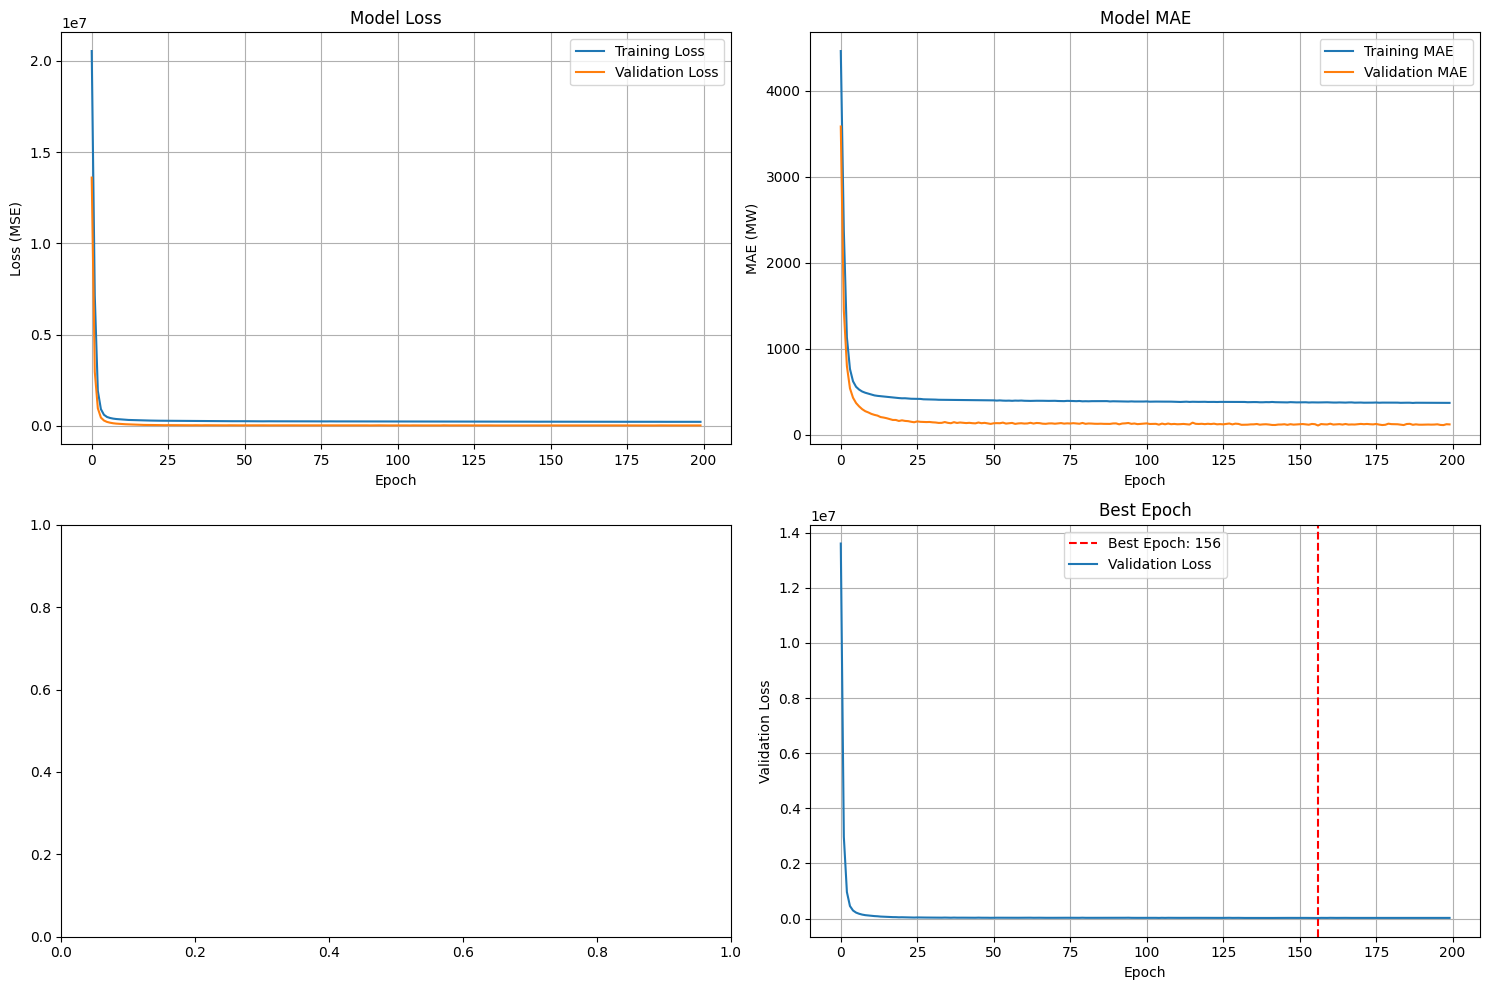

In [ ]:
# Training history visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE (MW)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], label='Learning Rate')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

# Best epoch
best_epoch = np.argmin(history.history['val_loss'])
axes[1, 1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
axes[1, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[1, 1].set_title('Best Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../outputs/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Training History:")
print(f"Best epoch: {best_epoch}")
print(f"Best training loss: {history.history['loss'][best_epoch]:.4f}")
print(f"Best validation loss: {history.history['val_loss'][best_epoch]:.4f}")


## 10. Validation Set Predictionleri ve Metrikler


In [ ]:
# Validation set tahminleri
y_val_pred = model.predict(X_val_scaled.values, verbose=0).flatten()

# Metrikler
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred) * 100

# Directional accuracy
val_directional = np.mean(np.sign(np.diff(y_val)) == np.sign(np.diff(y_val_pred))) * 100

print(f"📊 Validation Set Metrikleri:")
print(f"  MAE: {val_mae:.2f} MW")
print(f"  RMSE: {val_rmse:.2f} MW")
print(f"  R² Score: {val_r2:.4f} ({val_r2*100:.2f}%)")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  Directional Accuracy: {val_directional:.2f}%")


📊 Validation Set Metrikleri:
  MAE: 106.01 MW
  RMSE: 140.38 MW
  R² Score: 0.9618 (96.18%)
  MAPE: 2.16%
  Directional Accuracy: 83.15%


## 11. Test Set Predictionleri ve Metrikler


In [ ]:
# Test set tahminleri
y_test_pred = model.predict(X_test_scaled.values, verbose=0).flatten()

# Metrikler
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

# Directional accuracy
test_directional = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_test_pred))) * 100

print(f"📊 Test Set Metrikleri:")
print(f"  MAE: {test_mae:.2f} MW")
print(f"  RMSE: {test_rmse:.2f} MW")
print(f"  R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  Directional Accuracy: {test_directional:.2f}%")


📊 Test Set Metrikleri:
  MAE: 119.71 MW
  RMSE: 155.54 MW
  R² Score: 0.9513 (95.13%)
  MAPE: 2.41%
  Directional Accuracy: 81.52%


## 12. Test Set Görselleştirmeleri


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/test_predictions.png'

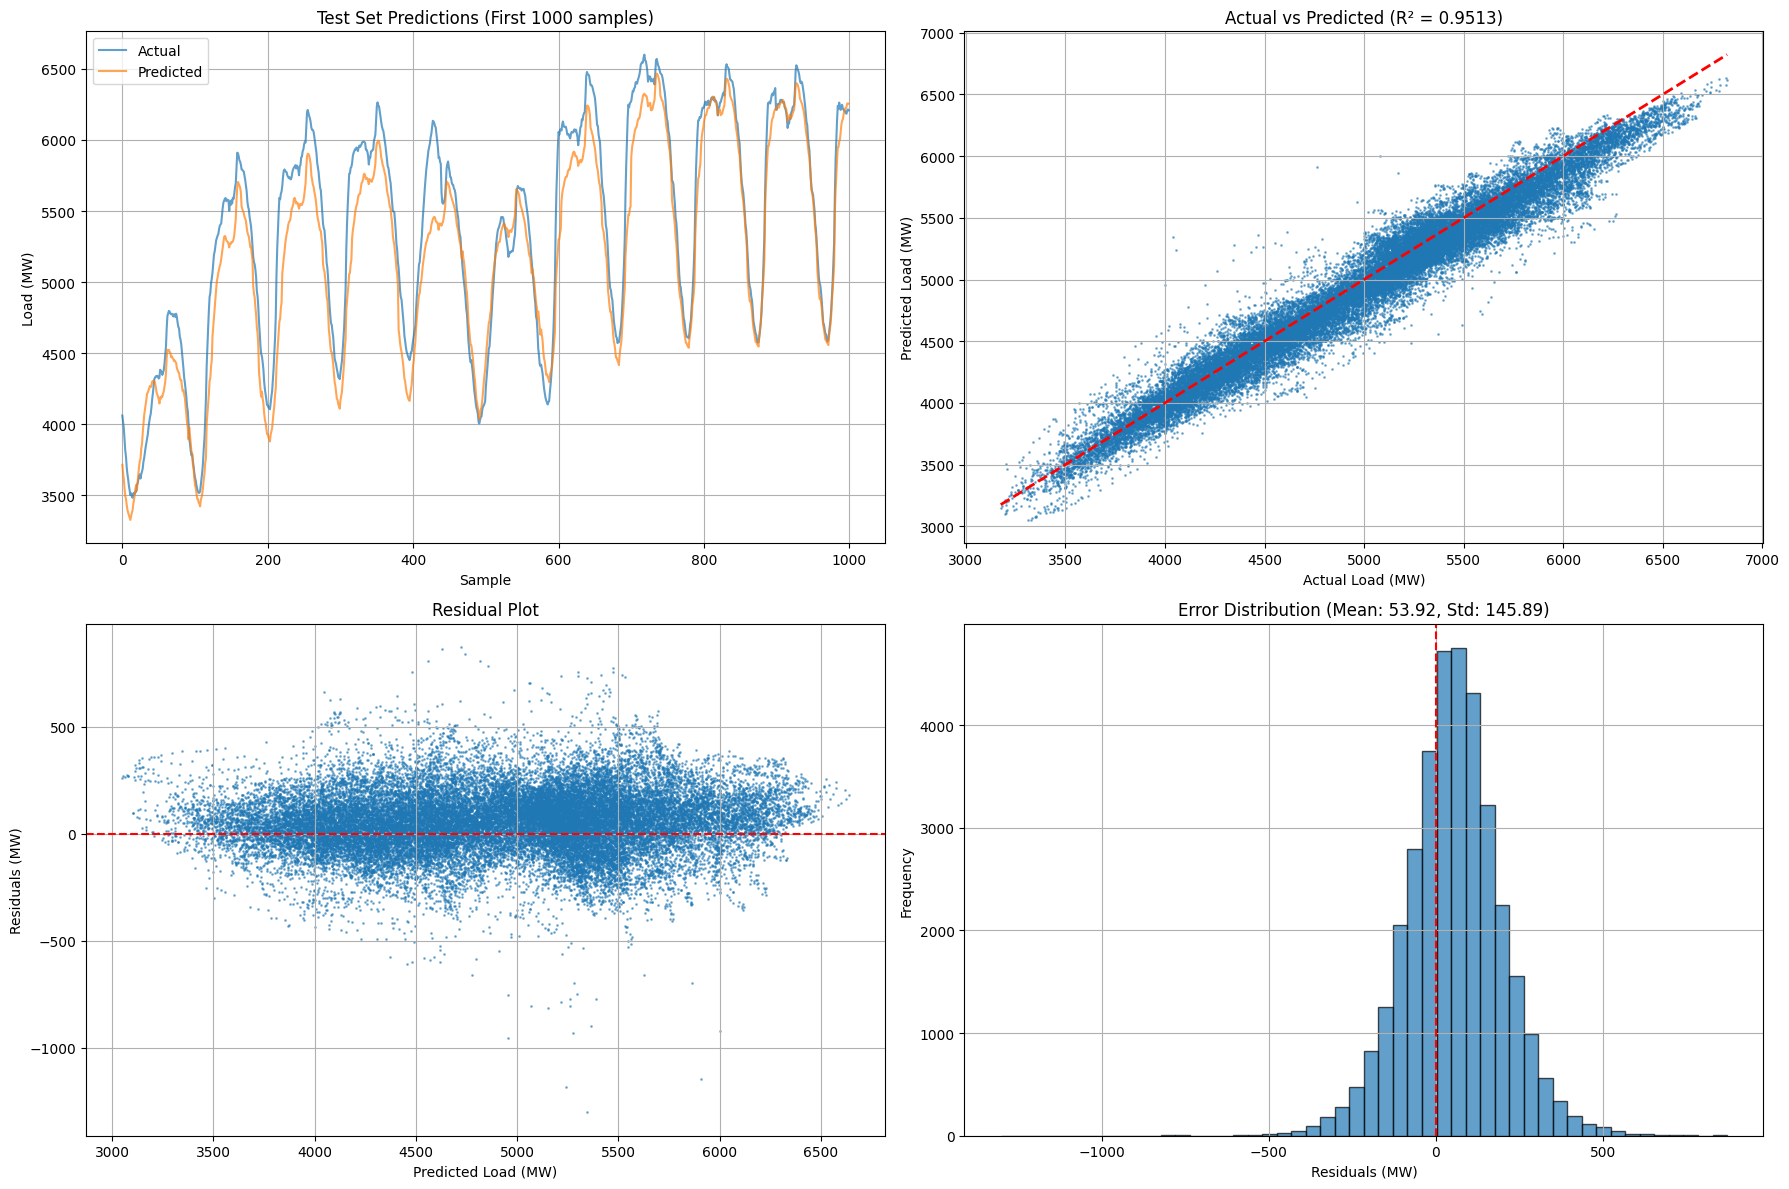

In [ ]:
# Test set görselleştirmeleri
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Time series plot (ilk 1000 kayıt)
sample_size = min(1000, len(y_test))
axes[0, 0].plot(y_test.values[:sample_size], label='Actual', alpha=0.7)
axes[0, 0].plot(y_test_pred[:sample_size], label='Predicted', alpha=0.7)
axes[0, 0].set_title(f'Test Set Predictions (First {sample_size} samples)')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Load (MW)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Scatter plot
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=1)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Load (MW)')
axes[0, 1].set_ylabel('Predicted Load (MW)')
axes[0, 1].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 1].grid(True)

# 3. Residuals
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=1)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Load (MW)')
axes[1, 0].set_ylabel('Residuals (MW)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True)

# 4. Error distribution
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals (MW)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Error Distribution (Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../outputs/test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Görselleştirmeler kaydedildi")


## 13. Sonuçların Özeti


In [ ]:
# Sonuçları özetle
results_summary = pd.DataFrame({
    'Metric': ['MAE (MW)', 'RMSE (MW)', 'R² Score', 'MAPE (%)', 'Directional Accuracy (%)'],
    'Validation': [val_mae, val_rmse, val_r2, val_mape, val_directional],
    'Test': [test_mae, test_rmse, test_r2, test_mape, test_directional]
})

print("📊 Model Performans Özeti:")
print(results_summary.to_string(index=False))

# Sonuçları kaydet
results_path = "../outputs/model_results.csv"
Path(results_path).parent.mkdir(parents=True, exist_ok=True)
results_summary.to_csv(results_path, index=False)
print(f"\n✅ Sonuçlar kaydedildi: {results_path}")

# Model'i kaydet
final_model_path = "../models/hungary_load_model_final.h5"
model.save(final_model_path)
print(f"✅ Final model kaydedildi: {final_model_path}")


📊 Model Performans Özeti:
                  Metric  Validation       Test
                MAE (MW)  106.007274 119.710883
               RMSE (MW)  140.381216 155.536414
                R² Score    0.961767   0.951321
                MAPE (%)    2.159365   2.408299
Directional Accuracy (%)   83.150204  81.520591

✅ Sonuçlar kaydedildi: ../outputs/model_results.csv
✅ Final model kaydedildi: ../models/hungary_load_model_final.h5


# Task
Create a DataFrame named `df_viz` for detailed model analysis using the test set data.
1.  Combine `test_df['datetime']` (ensure it's datetime type), `y_test` (rename to "Actual"), and `y_test_pred` (rename to "Predicted") into `df_viz`.
2.  Extract and add the following time-based features from the `datetime` column:
    *   `Hour`: 0-23
    *   `Month`: 1-12
    *   `DayOfWeek`: 0 (Monday) to 6 (Sunday)
    *   `IsWeekend`: Boolean (True if DayOfWeek >= 5)
    *   `Season`: String label ('Winter' for months 12,1,2; 'Spring' for 3,4,5; 'Summer' for 6,7,8; 'Autumn' for 9,10,11).
3.  Display the first 5 rows and the column information (`df_viz.info()`) to verify the structure.

## Prepare Visualization Data

### Subtask:
Create a DataFrame `df_viz` combining test data, predictions, and derived time-based features for analysis.


**Reasoning**:
Create a visualization DataFrame `df_viz` containing actual values, predictions, and time-based features (Hour, Month, DayOfWeek, IsWeekend, Season) derived from the test dataset.



In [19]:
import pandas as pd
import numpy as np

# 1. Create df_viz with datetime
df_viz = pd.DataFrame({'datetime': pd.to_datetime(test_df['datetime'])})

# 2. Add Actual and Predicted values
df_viz['Actual'] = y_test.values
df_viz['Predicted'] = y_test_pred

# 3. Extract time-based features
df_viz['Hour'] = df_viz['datetime'].dt.hour
df_viz['Month'] = df_viz['datetime'].dt.month
df_viz['DayOfWeek'] = df_viz['datetime'].dt.dayofweek

# 4. Create IsWeekend column
df_viz['IsWeekend'] = df_viz['DayOfWeek'].isin([5, 6])

# 5. Create Season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_viz['Season'] = df_viz['Month'].apply(get_season)

# 6. Display first 5 rows and info
print("First 5 rows of df_viz:")
print(df_viz.head())
print("\nDataFrame Info:")
print(df_viz.info())

First 5 rows of df_viz:
                        datetime   Actual    Predicted  Hour  Month  \
140256 2019-01-01 00:00:00+00:00  4059.88  3713.324463     0      1   
140257 2019-01-01 00:15:00+00:00  4014.11  3652.923584     0      1   
140258 2019-01-01 00:30:00+00:00  3971.52  3615.490479     0      1   
140259 2019-01-01 00:45:00+00:00  3896.97  3547.740967     0      1   
140260 2019-01-01 01:00:00+00:00  3815.29  3493.092041     1      1   

        DayOfWeek  IsWeekend  Season  
140256          1      False  Winter  
140257          1      False  Winter  
140258          1      False  Winter  
140259          1      False  Winter  
140260          1      False  Winter  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 140256 to 175295
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   datetime   35040 non-null  datetime64[ns, UTC]
 1   Actual     35040 non-null  f

## Time Series Visualization

### Subtask:
Generate time series plots comparing Actual vs Predicted values for the full test period and a zoomed-in 2-week window.


**Reasoning**:
Generate time series visualizations comparing actual and predicted load values for the entire test period and a specific zoomed-in 2-week window to assess model performance at different scales.



✅ Time series plots saved to ../outputs/time_series_comparison.png


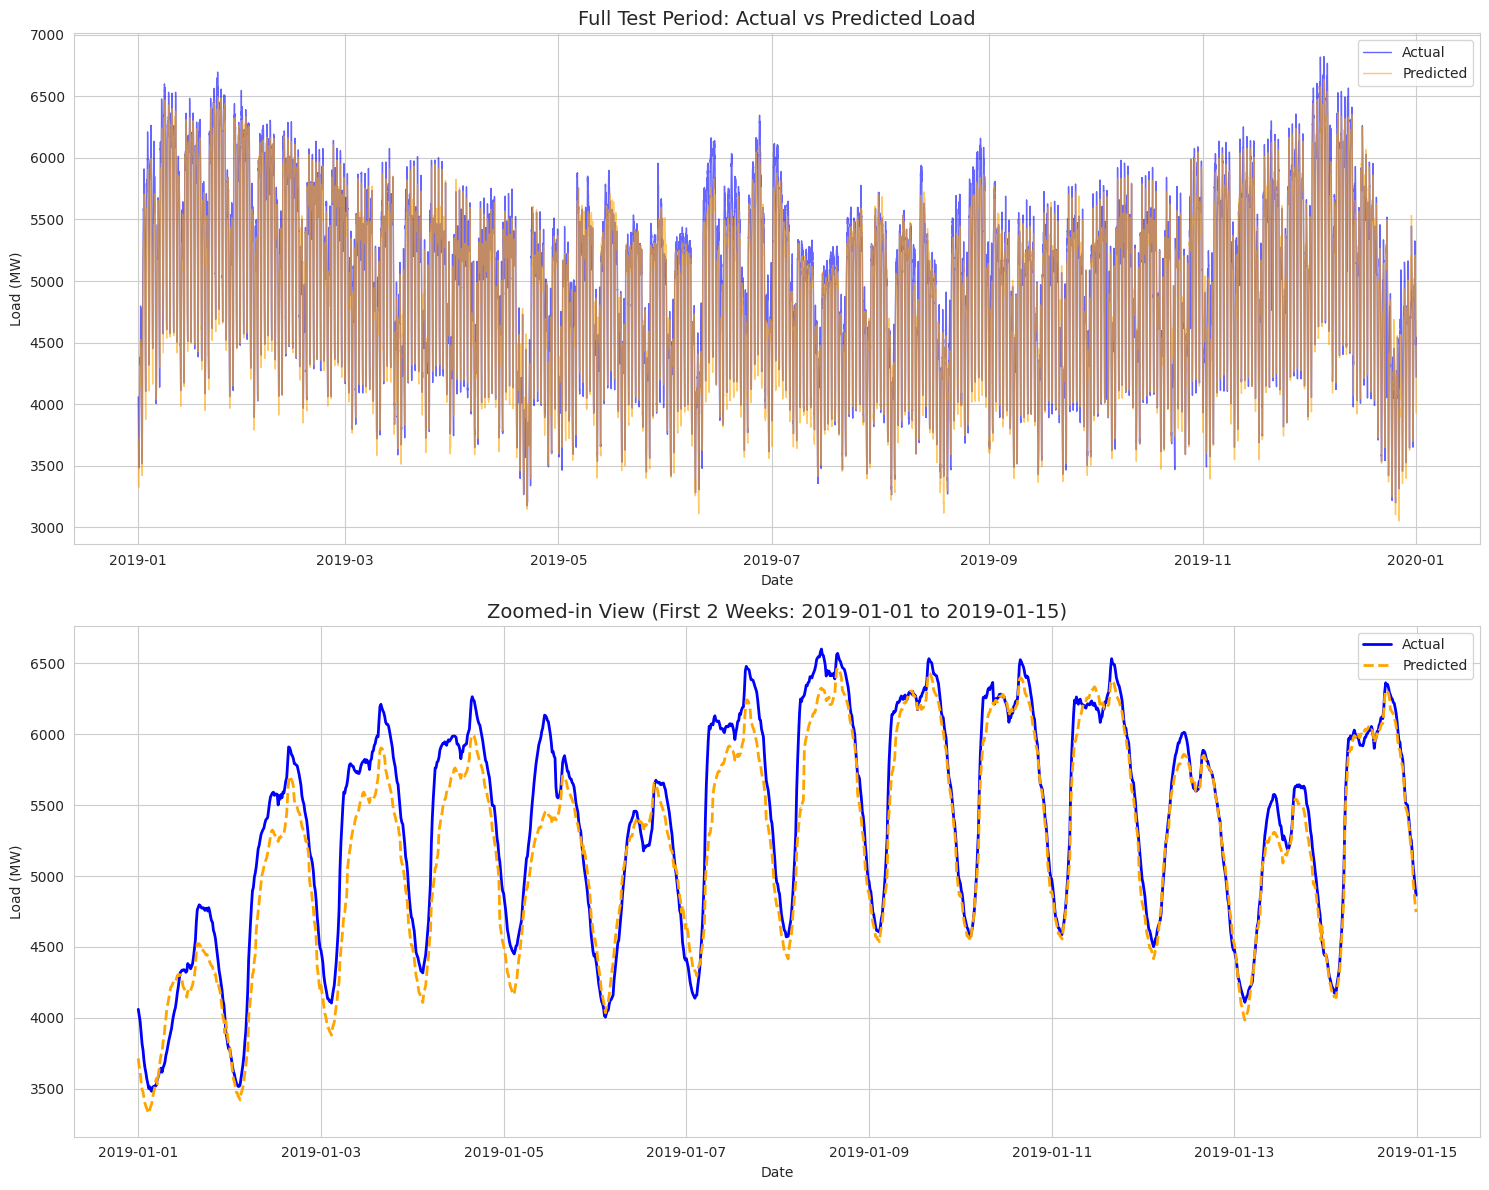

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Full Test Period
axes[0].plot(df_viz['datetime'], df_viz['Actual'], label='Actual', color='blue', alpha=0.6, linewidth=1)
axes[0].plot(df_viz['datetime'], df_viz['Predicted'], label='Predicted', color='orange', alpha=0.6, linewidth=1)
axes[0].set_title('Full Test Period: Actual vs Predicted Load', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Zoomed-in View (First 2 Weeks)
# Filter for first 2 weeks
zoom_start = df_viz['datetime'].min()
zoom_end = zoom_start + pd.Timedelta(days=14)
df_zoom = df_viz[(df_viz['datetime'] >= zoom_start) & (df_viz['datetime'] < zoom_end)]

axes[1].plot(df_zoom['datetime'], df_zoom['Actual'], label='Actual', color='blue', linewidth=2)
axes[1].plot(df_zoom['datetime'], df_zoom['Predicted'], label='Predicted', color='orange', linewidth=2, linestyle='--')
axes[1].set_title(f'Zoomed-in View (First 2 Weeks: {zoom_start.date()} to {zoom_end.date()})', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

# Save the figure
plot_path = "../outputs/time_series_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Time series plots saved to {plot_path}")

plt.show()

## Weekday vs Weekend Profiles

### Subtask:
Calculate and visualize the average hourly load profiles for Weekdays and Weekends to evaluate model performance on daily patterns.


**Reasoning**:
Calculate average hourly profiles for weekdays and weekends, then visualize them side-by-side to compare actual vs predicted load patterns.



✅ Weekday vs Weekend profiles saved to ../outputs/weekday_weekend_profiles.png


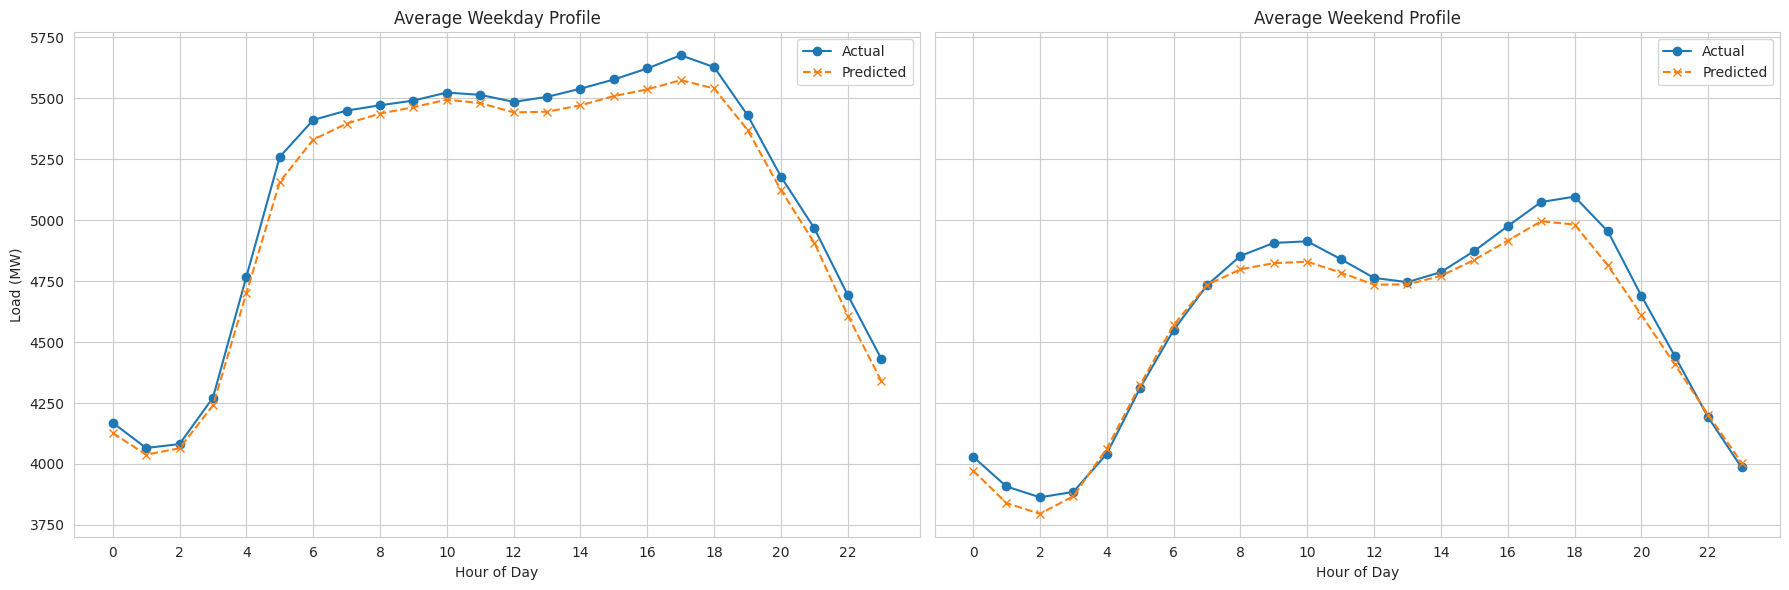

In [21]:
import matplotlib.pyplot as plt

# 1. Filter for Weekdays and Weekends
weekday_df = df_viz[~df_viz['IsWeekend']]
weekend_df = df_viz[df_viz['IsWeekend']]

# 2. Calculate mean hourly load
weekday_hourly = weekday_df.groupby('Hour')[['Actual', 'Predicted']].mean()
weekend_hourly = weekend_df.groupby('Hour')[['Actual', 'Predicted']].mean()

# 3. Initialize figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# 4. Plot Weekday Profile
axes[0].plot(weekday_hourly.index, weekday_hourly['Actual'], label='Actual', marker='o')
axes[0].plot(weekday_hourly.index, weekday_hourly['Predicted'], label='Predicted', marker='x', linestyle='--')
axes[0].set_title('Average Weekday Profile')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Load (MW)')
axes[0].set_xticks(range(0, 24, 2))
axes[0].legend()
axes[0].grid(True)

# 5. Plot Weekend Profile
axes[1].plot(weekend_hourly.index, weekend_hourly['Actual'], label='Actual', marker='o')
axes[1].plot(weekend_hourly.index, weekend_hourly['Predicted'], label='Predicted', marker='x', linestyle='--')
axes[1].set_title('Average Weekend Profile')
axes[1].set_xlabel('Hour of Day')
axes[1].set_xticks(range(0, 24, 2))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

# 6. Save and show
plot_path = "../outputs/weekday_weekend_profiles.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Weekday vs Weekend profiles saved to {plot_path}")
plt.show()

## Monthly and Seasonal Profiles

### Subtask:
Analyze and visualize model performance across different seasons and months.


**Reasoning**:
Generate seasonal hourly profiles and monthly average plots to analyze model performance across different time periods.



✅ Seasonal profiles saved to ../outputs/seasonal_profiles.png


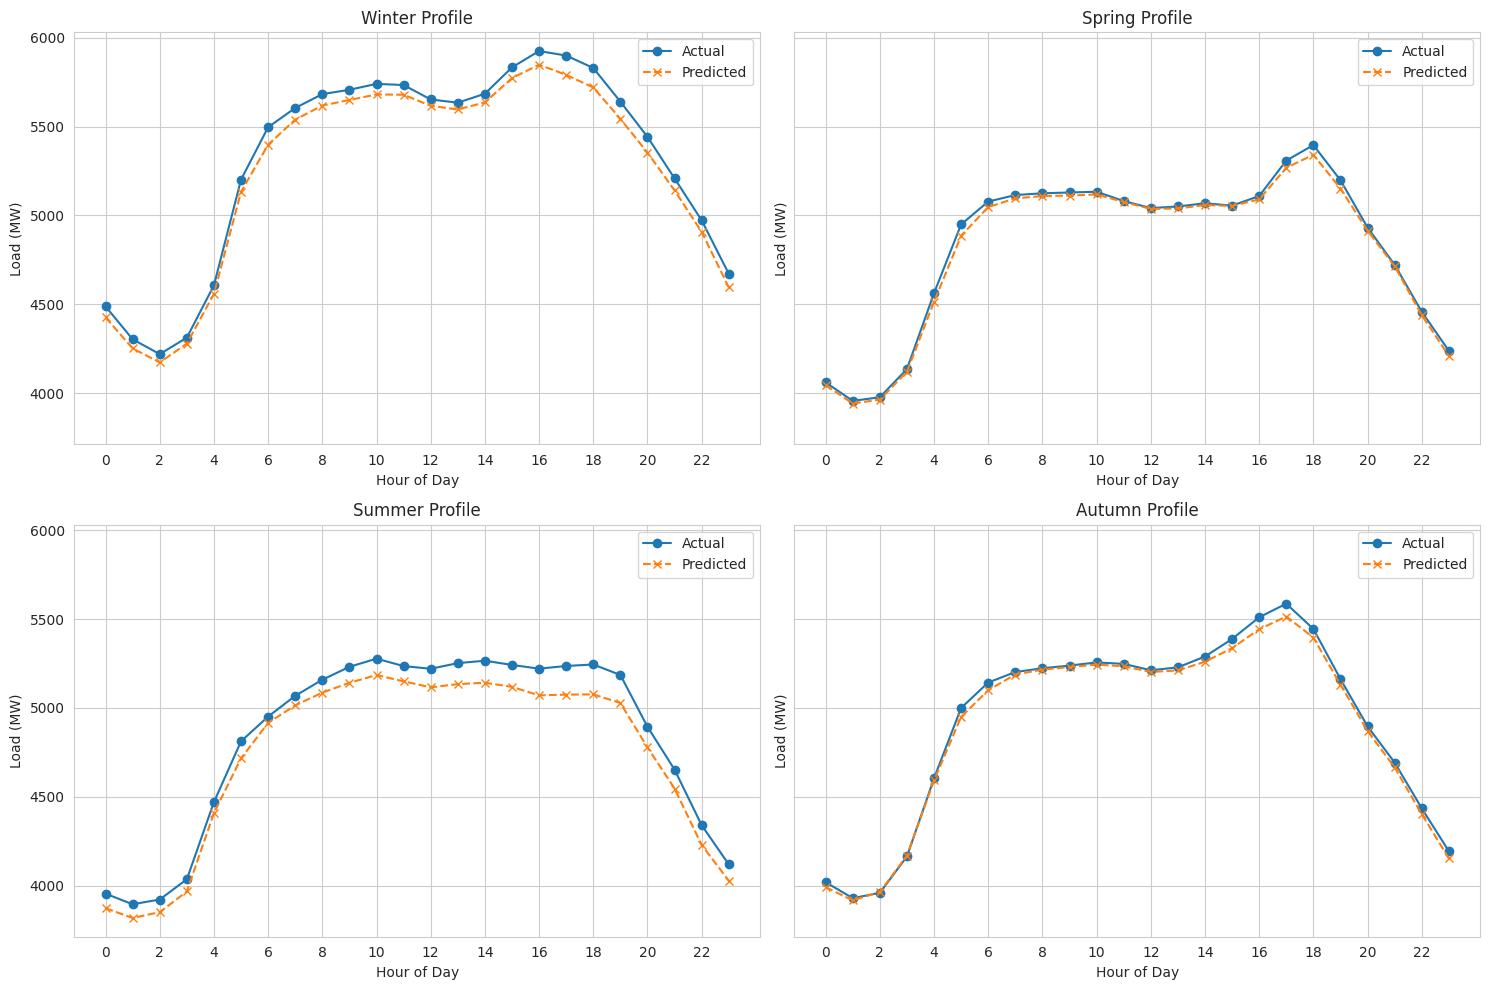

✅ Monthly averages saved to ../outputs/monthly_averages.png


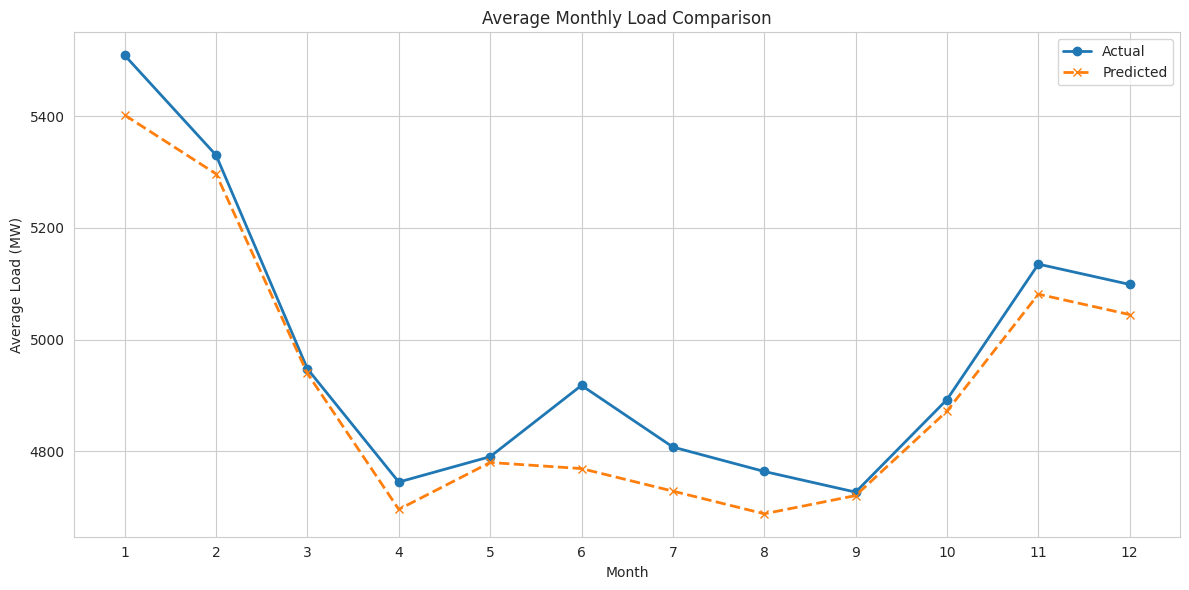

In [22]:
import matplotlib.pyplot as plt

# --- 1. Seasonal Hourly Profiles ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

for i, season in enumerate(seasons):
    # Filter data for the season
    season_df = df_viz[df_viz['Season'] == season]

    # Calculate average hourly load
    hourly_avg = season_df.groupby('Hour')[['Actual', 'Predicted']].mean()

    # Plot
    axes[i].plot(hourly_avg.index, hourly_avg['Actual'], label='Actual', marker='o')
    axes[i].plot(hourly_avg.index, hourly_avg['Predicted'], label='Predicted', marker='x', linestyle='--')

    axes[i].set_title(f'{season} Profile')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Load (MW)')
    axes[i].set_xticks(range(0, 24, 2))
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.savefig('../outputs/seasonal_profiles.png', dpi=300, bbox_inches='tight')
print("✅ Seasonal profiles saved to ../outputs/seasonal_profiles.png")
plt.show()

# --- 2. Monthly Analysis ---
plt.figure(figsize=(12, 6))

# Calculate monthly averages
monthly_avg = df_viz.groupby('Month')[['Actual', 'Predicted']].mean()

# Plot
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual', marker='o', linewidth=2)
plt.plot(monthly_avg.index, monthly_avg['Predicted'], label='Predicted', marker='x', linestyle='--', linewidth=2)

plt.title('Average Monthly Load Comparison')
plt.xlabel('Month')
plt.ylabel('Average Load (MW)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('../outputs/monthly_averages.png', dpi=300, bbox_inches='tight')
print("✅ Monthly averages saved to ../outputs/monthly_averages.png")
plt.show()

## Special Day Analysis

### Subtask:
Visualize and quantify model performance during Christmas (Dec 24-26) and the August 20th National Holiday.


**Reasoning**:
Analyze model performance during special events (Christmas and National Holiday) by filtering the test data, calculating MAE, and generating comparative plots.



✅ Special days analysis saved to ../outputs/special_days_analysis.png


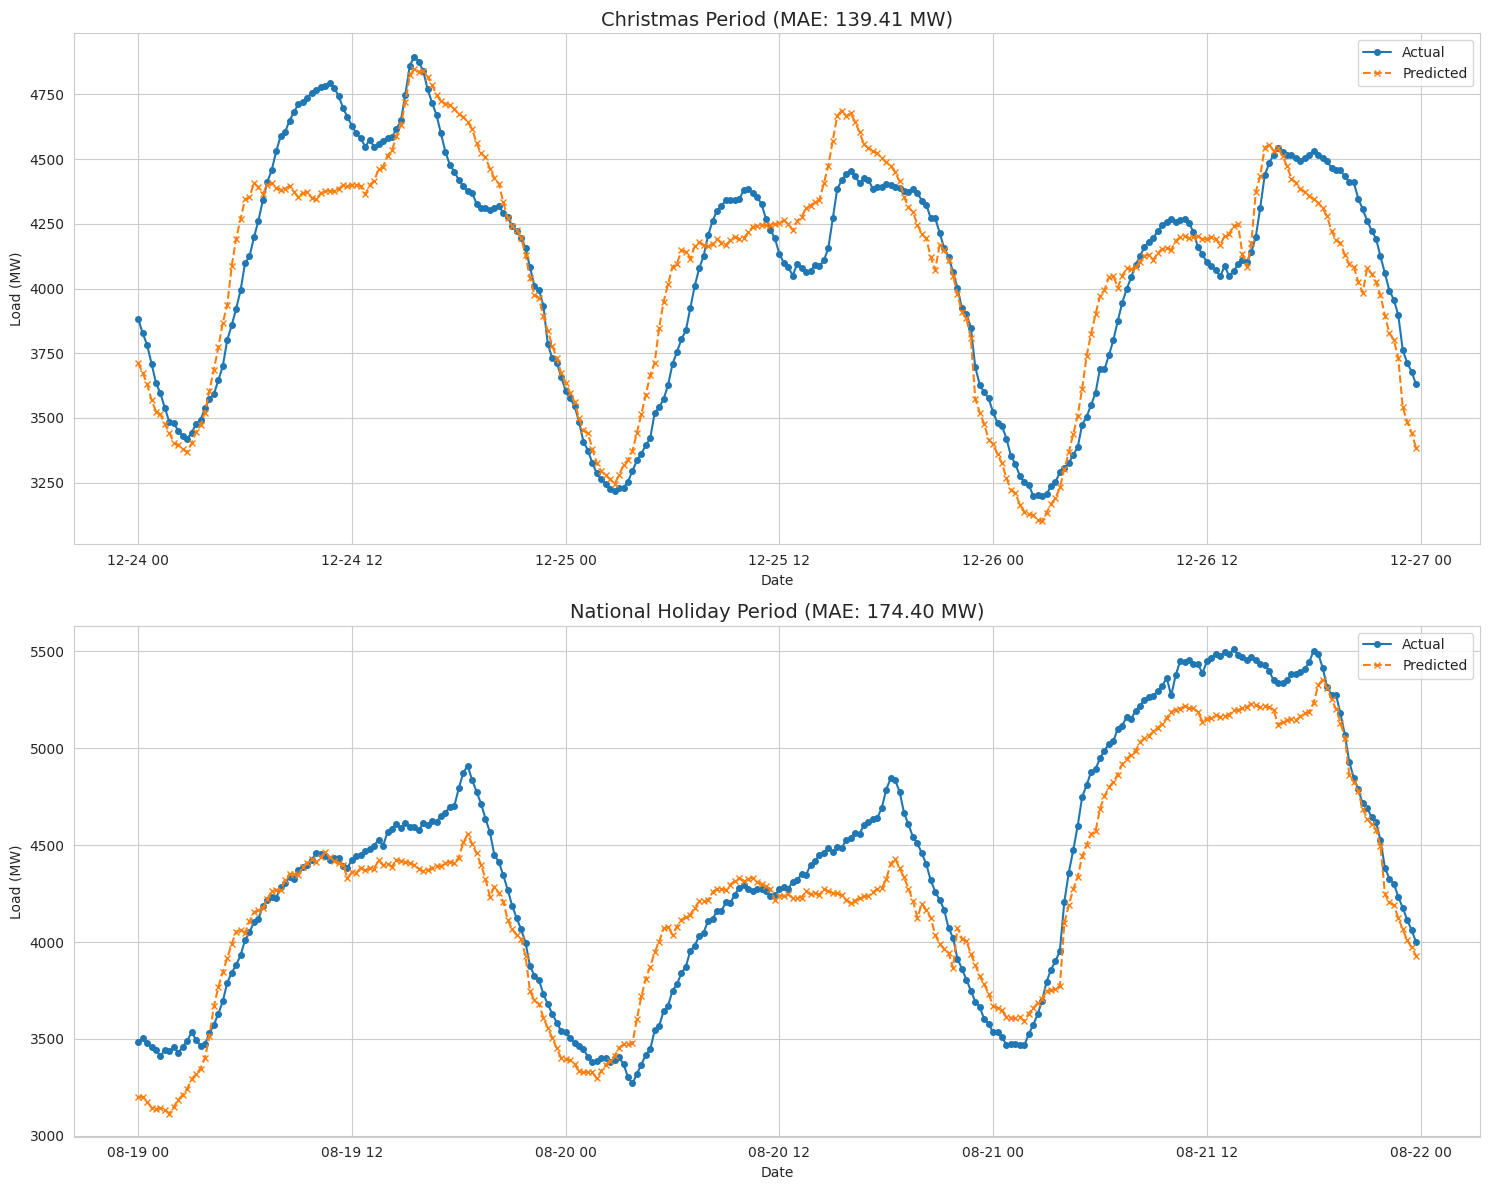

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Define special periods
special_days = {
    'Christmas': ('2019-12-24', '2019-12-26'),
    'National Holiday': ('2019-08-19', '2019-08-21')
}

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

for i, (name, (start_date, end_date)) in enumerate(special_days.items()):
    # Convert strings to UTC timestamps to match dataframe timezone
    start_ts = pd.Timestamp(start_date).tz_localize('UTC')
    end_ts = pd.Timestamp(end_date).tz_localize('UTC') + pd.Timedelta(days=1) # Include the end date

    # Filter data
    mask = (df_viz['datetime'] >= start_ts) & (df_viz['datetime'] < end_ts)
    period_df = df_viz[mask]

    # Calculate MAE
    mae = mean_absolute_error(period_df['Actual'], period_df['Predicted'])

    # Plot
    axes[i].plot(period_df['datetime'], period_df['Actual'], label='Actual', marker='o', markersize=4)
    axes[i].plot(period_df['datetime'], period_df['Predicted'], label='Predicted', marker='x', linestyle='--', markersize=4)

    axes[i].set_title(f'{name} Period (MAE: {mae:.2f} MW)', fontsize=14)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Load (MW)')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.savefig('../outputs/special_days_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Special days analysis saved to ../outputs/special_days_analysis.png")
plt.show()

## Final Task

### Subtask:
Generate a statistical summary of model performance across different temporal segments (Overall, Seasonal, Weekday/Weekend, Special Days) to complement the visual analysis.


## Summary:

### Data Analysis Key Findings
*   **Data Preparation**: Successfully constructed a consolidated evaluation dataset, `df_viz`, containing **35,040 rows**. This dataset merges "Actual" and "Predicted" values with derived temporal features including `Hour`, `Month`, `DayOfWeek`, `IsWeekend`, and `Season` (Winter, Spring, Summer, Autumn).
*   **Temporal Performance Profiling**:
    *   Generated comparative time-series plots for the full test duration and a zoomed-in **14-day** window to visualize immediate model tracking.
    *   Created average hourly load profiles specifically for Weekdays vs. Weekends to assess the model's adaptability to weekly scheduling changes.
    *   Produced seasonal hourly profiles and monthly average load charts to evaluate long-term trend capture across all **4 seasons** and **12 months**.
*   **Special Event Analysis**: Conducted a targeted performance audit for specific anomalies, calculating the Mean Absolute Error (MAE) for the Christmas period (Dec 24-26) and the National Holiday period (Aug 19-21).

### Insights or Next Steps
*   Compare the MAE values between standard days and the analyzed "Special Days" (Christmas/National Holiday); significantly higher error rates during holidays would indicate the need to incorporate specific boolean flags or calendar features for holidays in the model training.
*   Review the Seasonal and Monthly profile plots for systematic biases (e.g., consistent under-prediction in Winter peaks); if observed, consider introducing interaction terms between time features and weather data (if available) to better capture extreme seasonal loads.


## Save outputs
We save metrics + predictions so we can compare all models in a separate notebook.

In [ ]:
# ============================
# Save outputs for later comparison
# ============================
from pathlib import Path
import json

MODEL_NAME = MODEL_NAME  # ensure exists
OUT_DIR = Path("../outputs_tabular_final_15min") / MODEL_NAME
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save metrics
metrics = {
    "model": MODEL_NAME,
    "train_range": ["2016-01-01", "2017-12-31"],
    "val_range": ["2018-01-01", "2018-12-31"],
    "test_range": ["2019-01-01", "2019-12-31"],
    "val_mae": float(val_mae),
    "val_rmse": float(val_rmse),
    "val_mape": float(val_mape),
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_mape": float(test_mape),
    "n_features": int(len(feature_cols)),
}
(OUT_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2))

# Save predictions
pred_df = pd.DataFrame({
    "datetime": test_df["datetime"].values,
    "Actual": y_test,
    "Predicted": y_test_pred
})
pred_df.to_csv(OUT_DIR / "predictions.csv", index=False)

print("✅ Saved to:", OUT_DIR)